# Credit Card Fraud Detection Model
---------------------
 - 결제, 이체 등의 과정에서 발생하는 사기를 찾아내는 모델입니다.
 - 사기인 경우의 수가 적기 때문에, 이 부분에서 예측모델을 만들 때 문제가 생길 것으로 예상하고 있습니다.
 - 따라서, 사기인 데이터를 늘려주는 방식인 OverSampling을 통해서 해결할 것입니다.

## Data Load

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder, TargetEncoder, QuantileEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [2]:
data = pd.read_csv('sec2_data.csv') 

## Data EDA

In [3]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# 현재 데이터에는 결측치가 없습니다.
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# step, isFlaggedFraud -> 
# nameOrig, nameDest -> 이 두 Column은 이름과 같은 것이기에 drop후 model을 만드려고 합니다.
data = data.drop(['step', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis = 1)

([<matplotlib.patches.Wedge at 0x24221d89e50>,
 [Text(-1.099990955625572, 0.004460666087110192, 'Not Fraud'),
  Text(1.0999909559371663, -0.004460589247970448, 'Fruad')],
 [Text(-0.5999950667048575, 0.002433090592969195, '99.87'),
  Text(0.599995066874818, -0.002433048680711153, '0.13')])

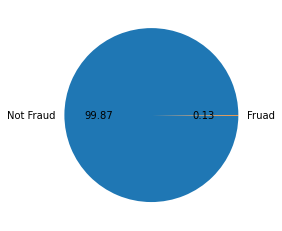

In [9]:
# Target의 분포를 살펴보면 'Not Fraud' 99% 'Fraud' 1% 로 불균형 상태이다.

plt.pie(data['isFraud'].value_counts(normalize = True), labels = ['Not Fraud', 'Fruad'], autopct='%.2f')

## Data Preprocessing

In [11]:
# train, val, test data로 Split

X = data[data.columns[:-1]]
y = data[data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(4072076, 6) (1018020, 6) (1272524, 6)
(4072076,) (1018020,) (1272524,)


In [13]:
labelencoder = LabelEncoder()

X_train['type'] = labelencoder.fit_transform(X_train['type'])

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [15]:
X_test['type'] = labelencoder.transform(X_test['type'])

C:\Users\bjw97\AppData\Local\Temp/ipykernel_18260/1933959192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['type'] = labelencoder.transform(X_test['type'])


## Logistic Regression 

- 분류 모델에서는 보통 최빈값을 기준모델로 설정
- 그러나, 이 데이터셋의 경우에서는 데이터 불균형이 너무심하기 때문에 가장 간단한 분류모델인 Logistic Regression으로 설정하려 합니다.
- 또한, 현재 target이 0으로 몰려 있는 상태에서 모델을 모두 0으로 예측하면 높은 accuracy가 나오게 된다.
- 따라서, 이 프로젝트에서는 f1_score를 기본 평가지표로 사용하려 한다.

In [50]:
logregression = LogisticRegression()
logregression.fit(X_train_over, y_train_over)

LogisticRegression()

In [51]:
logregression.score(X_test, y_test)

0.7060055448855974

In [53]:
logreg_y_pred = logregression.predict(X_test)

In [54]:
confusion_matrix(y_test, logreg_y_pred)

array([[896818, 374086],
       [    29,   1591]], dtype=int64)

In [57]:
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83   1270904
           1       0.00      0.98      0.01      1620

    accuracy                           0.71   1272524
   macro avg       0.50      0.84      0.42   1272524
weighted avg       1.00      0.71      0.83   1272524



## Decision Tree

In [16]:
dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train_over, y_train_over)

DecisionTreeClassifier()

In [27]:
dt_classifier.score(X_test, y_test)

0.9994538413420886

In [28]:
dt_y_pred = dt_classifier.predict(X_test)

In [41]:
np.unique(dt_y_pred, return_counts = True)

(array([0, 1], dtype=int64), array([1270257,    2267], dtype=int64))

In [29]:
accuracy_score(y_test, dt_y_pred)

0.9994538413420886

In [30]:
f1_score(y_test,dt_y_pred)

0.8211988680216106

In [31]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.70      0.99      0.82      1620

    accuracy                           1.00   1272524
   macro avg       0.85      0.99      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



In [44]:
confusion_matrix(y_test, dt_y_pred)

array([[1270233,     671],
       [     24,    1596]], dtype=int64)

In [22]:
roc_score = roc_auc_score(y_test, dt_y_pred)
roc_score

0.9923286072719075

## Random Forest